In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import torch.nn as nn
from transformers import BertModel
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import json 
import torch 
import random 
from ray.data.preprocessor import Preprocessor
#from ray.train.torch import get_device 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
import numpy as np
import os
import ray 
import logging
logging.getLogger('ray').setLevel(logging.ERROR)

In [190]:
from ray.air import  session

import ray.train as train
from ray.train import  RunConfig, CheckpointConfig, ScalingConfig
from ray.train import get_context
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

In [116]:
import ray
if ray.is_initialized():
    ray.shutdown()
ray.init(
    log_to_driver=False,
    _metrics_export_port=None
)
import sys
sys.path.append("..")

python(96925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(96932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2026-01-05 17:13:50,042	INFO worker.py:2023 -- Started a local Ray instance.
2026-01-05 17:13:50,096	INFO packaging.py:588 -- Creating a file package for local module '/Users/aravindrajeshmenon/Documents/DataScienceProjects/Projects/reddit_nlp_classification'.
2026-01-05 17:13:50,131	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_12e65dbf03989aae.zip' (4.37MiB) to Ray cluster...
2026-01-05 17:1

In [117]:
ray.cluster_resources()

{'CPU': 8.0,
 'object_store_memory': 1239038361.0,
 'node:127.0.0.1': 1.0,
 'memory': 2891089511.0,
 'node:__internal_head__': 1.0}

In [118]:
num_workers = 6 
resources_per_worker={"CPU": 1, "GPU": 0}

In [119]:
DATASET_LOC = os.path.join(os.getcwd(), 'data', 'reddit_posts_20251212_035106.parquet')

In [120]:
df = pd.read_parquet(DATASET_LOC)

In [121]:
df.head()

,post_id,title,subreddit
0,1pkhhxb,"Even the man behind ChatGPT, OpenAI CEO Sam Al...",technology
1,1pkh69t,"Palantir sues CEO of rival AI firm Percepta, a...",technology
2,1pkg053,'Architects of AI' named Time Magazine's Perso...,technology
3,1pkfqa0,Sam Altman expects OpenAI to exit ‘code red’ b...,technology
4,1pkfpmf,Broadcom reveals its mystery $10 billion custo...,technology


In [122]:
df['subreddit'].value_counts()

subreddit
entertainment            997
technology               989
science                  987
politics                 986
ArtificialInteligence    962
Name: count, dtype: int64

In [123]:
df = df.sample(frac = 1.0)

In [124]:
test_size = 0.2 
train_df, val_df = train_test_split(df, test_size = test_size, stratify = df['subreddit'], random_state = 13)
                                    

In [125]:
train_df['subreddit'].value_counts()

subreddit
entertainment            797
technology               791
politics                 789
science                  789
ArtificialInteligence    770
Name: count, dtype: int64

In [126]:
(val_df['subreddit'].value_counts() * (1-test_size))/(test_size)

subreddit
entertainment            800.0
science                  792.0
technology               792.0
politics                 788.0
ArtificialInteligence    768.0
Name: count, dtype: float64

## EDA 

Let us first visualise the number of examples per subreddit. 

In [127]:
counter = Counter(df['subreddit'])
counter.most_common()

[('entertainment', 997),
 ('technology', 989),
 ('science', 987),
 ('politics', 986),
 ('ArtificialInteligence', 962)]

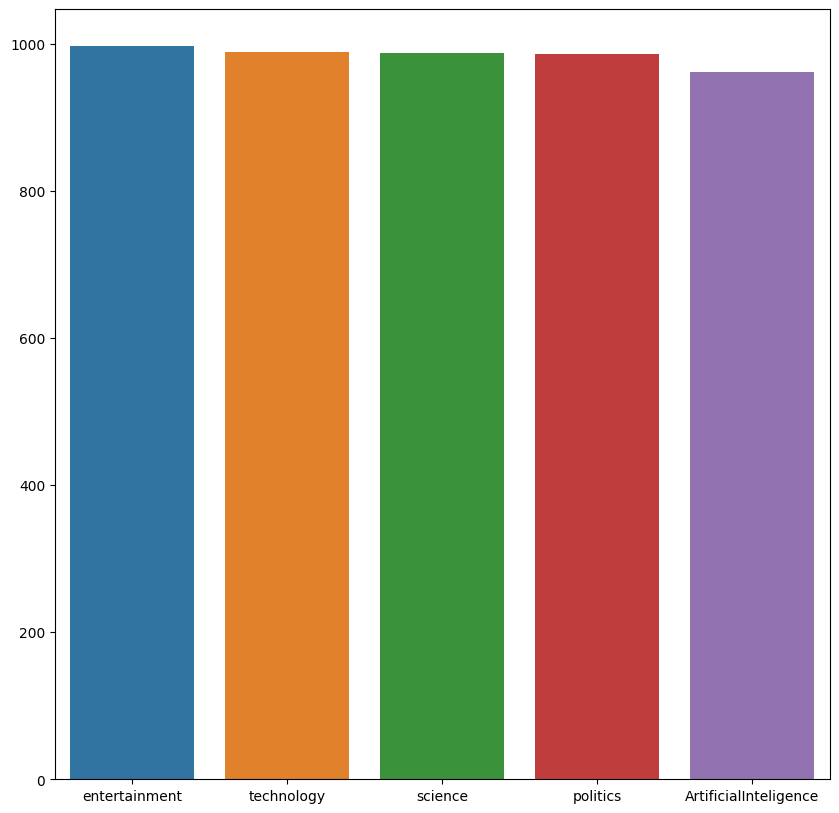

In [128]:
subreddit, counts = zip(*counter.most_common())
plt.figure(figsize = (10,10))
sns.barplot(x = list(subreddit), y = list(counts), hue = list(subreddit))
plt.show()

In [129]:
subreddits = df['subreddit'].unique().tolist()

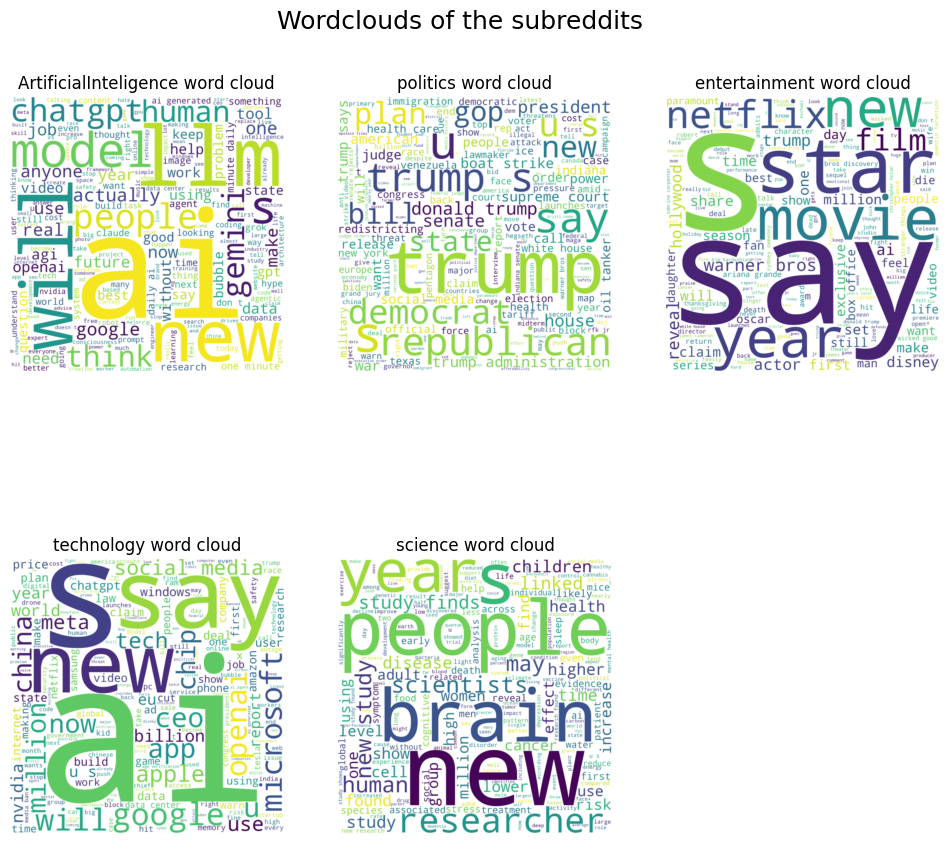

In [130]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Wordclouds of the subreddits", fontsize=18, y=0.95)

for sub, ax in zip(subreddits, axs.ravel()):
    stopwords = set(STOPWORDS)
    text = ' '.join(df[df['subreddit'] == sub]['title'].astype('str').tolist())
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    wordcloud = WordCloud(width=2000, height=2000, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sub} word cloud")
    ax.axis('off')

axs.ravel()[-1].axis('off')

plt.show()
        

In [131]:
def clean_text(text):
    stopwords = set(STOPWORDS)
    text = text.lower()
 
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text) 
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = text.strip()
    text = re.sub(r"http\S+", "", text)
    return text 
    

In [132]:
original_df = df.copy()
df['title'] = df['title'].map(clean_text)

In [133]:
print(original_df['title'][0])
print(df['title'][0])

Even the man behind ChatGPT, OpenAI CEO Sam Altman is worried about the ‘rate of change that’s happening in the world right now’ thanks to AI
even man behind chatgpt openai ceo sam altman worried rate change s happening world right now thanks ai


In [134]:
df = df.drop(columns = ['post_id'], axis = 1) 
df = df.dropna()

In [135]:
class_to_index = {k:i for i, k in enumerate(subreddits)}
class_to_index

{'ArtificialInteligence': 0,
 'politics': 1,
 'entertainment': 2,
 'technology': 3,
 'science': 4}

In [136]:
num_classes = len(subreddits) 

In [137]:
index_to_class = {v:k for k,v in class_to_index.items()}
index_to_class

{0: 'ArtificialInteligence',
 1: 'politics',
 2: 'entertainment',
 3: 'technology',
 4: 'science'}

In [138]:
def encode(indices, class_to_index):
    return [class_to_index[index] for index in indices]


In [139]:
encode(df.sample(5)["subreddit"].values, class_to_index=class_to_index)

[1, 1, 2, 4, 2]

In [140]:
df['subreddit'] = df['subreddit'].map(class_to_index)

In [141]:
df

,title,subreddit
3877,m genuinely pissed gptzero keeps flagging writ...,0
4129,mypillow ceo mike lindell announces campaign m...,1
2572,eva green joining wednesday season 3 aunt ophelia,2
4296,2 us fighter jets fly gulf venezuela amid trum...,1
139,cursor s ceo believes openai anthropic competi...,3
...,...,...
3766,new season alpha arena launched,0
2560,corey feldman ex wife courtney anne settle div...,2
1432,study finds adults consumed ultra processed fo...,4
3993,indiana republicans block trump s redistrictin...,1


In [142]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [143]:
decode(df.head()["subreddit"].values, index_to_class=index_to_class)

['ArtificialInteligence',
 'politics',
 'entertainment',
 'politics',
 'technology']

In [144]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

In [145]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch['title'].tolist(), padding = 'longest',return_tensors = 'pt')
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["subreddit"]))

In [146]:
def preprocess(df, class_to_index:dict):
    df['title'] = df['title'].map(clean_text)
    df = df.drop(columns = ['post_id'], axis = 1) 
    df = df.dropna()
    df['subreddit'] = df['subreddit'].map(class_to_index)
    outputs = tokenize(df)
    return outputs
    

In [147]:
train_inputs = preprocess(train_df, class_to_index)
val_inputs = preprocess(val_df, class_to_index)

In [148]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [149]:
ds = ray.data.read_parquet(DATASET_LOC)
ds = ds.random_shuffle(seed= 43)
ds.take(1)

Parquet dataset sampling 0:   0%|                                                                             …

[2026-01-05 17:14:22,273 E 95283 6218757] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-05 17:14:46,539	INFO parquet_datasource.py:728 -- Estimated parquet encoding ratio is 1.475.
2026-01-05 17:14:46,540	INFO parquet_datasource.py:788 -- Estimated parquet reader batch size at 1082402 rows
2026-01-05 17:14:49,460	INFO logging.py:397 -- Registered dataset logger for dataset dataset_2_0
2026-01-05 17:14:49,464	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 17:14:49,464	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_2_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- limit=1 5: 0.00 row [00:00, ? row/s]

2026-01-05 17:14:49,862	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_2_0 execution finished in 0.40 seconds
2026-01-05 17:14:49,901	INFO util.py:257 -- Exiting prefetcher's background thread


[{'post_id': '1p6zlkq',
  'title': 'AI optimized content',
  'subreddit': 'ArtificialInteligence'}]

In [150]:
train_ds, val_ds = ds.train_test_split(test_size = 0.2, seed = 43)

2026-01-05 17:14:49,913	INFO logging.py:397 -- Registered dataset logger for dataset dataset_3_0
2026-01-05 17:14:49,921	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 17:14:49,922	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> TaskPoolMapOperator[Project] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|                                                                                              …

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- Project 5: 0.00 row [00:00, ? row/s]

- AggregateNumRows 6:   0%|                                                                                   …

2026-01-05 17:14:50,765	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_3_0 execution finished in 0.84 seconds
2026-01-05 17:14:50,780	INFO util.py:257 -- Exiting prefetcher's background thread
2026-01-05 17:14:50,787	INFO logging.py:397 -- Registered dataset logger for dataset dataset_1_0
2026-01-05 17:14:50,794	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 17:14:50,795	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

2026-01-05 17:14:51,082	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_1_0 execution finished in 0.29 seconds


In [151]:
sample_ds = train_ds.map_batches(preprocess, batch_format = 'pandas', fn_kwargs = {'class_to_index' : class_to_index})

In [152]:
sample_ds.take(1)

2026-01-05 17:14:51,115	INFO logging.py:397 -- Registered dataset logger for dataset dataset_7_0
2026-01-05 17:14:51,116	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 17:14:51,117	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

- MapBatches(preprocess) 2: 0.00 row [00:00, ? row/s]

2026-01-05 17:15:29,963	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_7_0 execution finished in 38.85 seconds
2026-01-05 17:15:29,971	INFO util.py:257 -- Exiting prefetcher's background thread


[{'ids': array([ 102, 4725, 7150, 2118,  103]),
  'masks': array([1, 1, 1, 1, 1]),
  'targets': 0}]

In [153]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [154]:
def load_dataset(num_samples = None):
    ds = ray.data.load_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed = 43)
    ds = ray.data.from_items(ds.take(num_sample) if num_samples else ds)
    return ds 

In [155]:
class CustomPreprocessor(Preprocessor):
    def _fit(self, ds):
        subs = ds.unique(column = 'subreddit')
        self.class_to_index = {tag: i for i, tag in enumerate(subs)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self 
    def _transform_pandas(self, batch):
        return preprocess(batch, class_to_index = self.class_to_index)
    

In [156]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

In [157]:
embedding_dim

768

In [158]:
text = ["Transfer learning with transformers for text classification.", "i hate ai. it really sucks", "man f this"]
batch = tokenizer(text, return_tensors="pt", padding="longest")
print(batch)
#batch = {k:torch.tensor(v) for k,v in batch.items()}
#print(batch)
result = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
seq, pool = result

{'input_ids': tensor([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,   103,
             0],
        [  102,   259,  6500, 30107,  4725,   205,   256,  9695,  1639,   784,
           103],
        [  102,   508,   125,   238,   103,     0,     0,     0,     0,     0,
             0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


In [159]:
class FineTunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FineTunedLLM,self).__init__()
        self.llm = llm 
        self.dropout_p = nn.Dropout(p = dropout_p)
        self.embedding_dim = llm.config.hidden_size
        self.fc1 = nn.Linear(self.embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = llm(input_ids = ids, attention_mask = masks)
        pool = self.dropout(pool)
        outputs = self.fc1(pool)
        return outputs
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)   ### -> automatically does forward layer logic onto the inputs
        y_pred = torch.argmax(z, dim = 1).cpu().numpy()
        return y_pred
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(inputs)
        z = nn.Softmax(z, dim = 1).cpu().numpy()
        return z
        
        
        
        

In [160]:
model = FineTunedLLM(llm, dropout_p = 0.5, embedding_dim = embedding_dim, num_classes = len(subreddits))

In [161]:
model.named_parameters

<bound method Module.named_parameters of FineTunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [162]:
def load_data(num_samples=None):
    ds = ray.data.read_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [163]:
def pad_array(arrs, dtype = np.int32):
    max_len = max(len(arr) for arr in arrs)
    padded_arr = np.zeros((arrs.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arrs):
        padded_arr[i][:len(row)] = row
    return padded_arr    
        

In [164]:
def collate_fn(batch):
    batch['ids'] = pad_array(batch['ids'])
    batch['masks'] = pad_array(batch['masks'])
    target_batch = {'ids' : torch.int32, 'masks' : torch.int32, 'targets' : torch.int32}
    tensor_batch = {}
    for key, item in batch.items():
        tensor_batch[key] = torch.as_tensor(item, dtype = target_batch[key])

    return tensor_batch    

In [165]:
collate_fn(sample_ds.take_batch(batch_size = 128))

2026-01-05 17:15:31,070	INFO logging.py:397 -- Registered dataset logger for dataset dataset_8_0
2026-01-05 17:15:31,076	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_8_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 17:15:31,077	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_8_0: InputDataBuffer[Input] -> LimitOperator[limit=128] -> TaskPoolMapOperator[MapBatches(preprocess)]


Running 0: 0.00 row [00:00, ? row/s]

- limit=128 1: 0.00 row [00:00, ? row/s]

- MapBatches(preprocess) 2: 0.00 row [00:00, ? row/s]

2026-01-05 17:15:31,671	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_8_0 execution finished in 0.59 seconds


{'ids': tensor([[  102,  4725,  7150,  ...,     0,     0,     0],
         [  102,   758, 27765,  ...,     0,     0,     0],
         [  102,  1641,   122,  ...,     0,     0,     0],
         ...,
         [  102,   265,  3927,  ...,     0,     0,     0],
         [  102, 10467, 22441,  ...,     0,     0,     0],
         [  102, 15557, 17327,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 2, 2, 0, 4, 2, 4, 2, 2, 0, 3, 3, 3, 0, 2, 0, 2, 3, 3, 2, 1, 4, 2, 2,
         0, 0, 4, 3, 4, 1, 1, 0, 2, 4, 0, 3, 2, 0, 4, 1, 2, 0, 0, 4, 1, 4, 1, 0,
         0, 4, 4, 3, 3, 0, 2, 2, 1, 1, 0, 4, 3, 4, 0, 3, 3, 1, 2, 4, 2, 1, 3, 3,
         1, 0, 4, 1, 4, 4, 4, 2, 3, 0, 1, 4, 3, 1, 2, 4, 4, 2, 1, 1, 0, 4, 2, 2,
         0, 1, 

In [166]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer): 
    model.train()
    loss = 0.0 
    ds_generator = ds.iter_torch_batches(batch_size = batch_size, collate_fn = collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()
        z = model(batch)
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()
        losses = loss_fn(z,targets)
        losses.backward()
        optimizer.step()
        loss += (J.detach().item() - loss) / (i + 1)
    return loss    

In [167]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [200]:
def train_loop_per_worker(config):
    class FineTunedLLM(nn.Module):
        def __init__(self, llm, dropout_p, embedding_dim, num_classes):
            super(FineTunedLLM,self).__init__()
            self.llm = llm 
            self.dropout_p = nn.Dropout(p = dropout_p)
            self.embedding_dim = llm.config.hidden_size
            self.fc1 = nn.Linear(self.embedding_dim, num_classes)
    
        def forward(self, batch):
            ids, masks = batch["ids"], batch["masks"]
            seq, pool = llm(input_ids = ids, attention_mask = masks)
            pool = self.dropout(pool)
            outputs = self.fc1(pool)
            return outputs
        
        @torch.inference_mode()
        def predict(self, batch):
            self.eval()
            z = self(inputs)   ### -> automatically does forward layer logic onto the inputs
            y_pred = torch.argmax(z, dim = 1).cpu().numpy()
            return y_pred
        @torch.inference_mode()
        def predict_proba(self, batch):
            self.eval()
            z = self(inputs)
            z = nn.Softmax(z, dim = 1).cpu().numpy()
            return z
    # Hyperparameters
    
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FineTunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // session.get_world_size()
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        checkpoint = TorchCheckpoint.from_model(model=model)
        session.report(metrics, checkpoint=checkpoint)

In [201]:
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [202]:
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,

)

In [203]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path="~/ray_results")

In [204]:
ds = load_data()
train_ds, val_ds = ds.train_test_split(test_size = 0.2, seed = 43)

Parquet dataset sampling 0:   0%|                                                                             …

2026-01-05 18:00:03,480	INFO parquet_datasource.py:728 -- Estimated parquet encoding ratio is 1.475.
2026-01-05 18:00:03,482	INFO parquet_datasource.py:788 -- Estimated parquet reader batch size at 1082402 rows
2026-01-05 18:00:03,499	INFO logging.py:397 -- Registered dataset logger for dataset dataset_70_0
2026-01-05 18:00:03,503	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_70_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 18:00:03,504	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_70_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> TaskPoolMapOperator[Project] -> AggregateNumRows[AggregateNumRows]


Running 0:   0%|                                                                                              …

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

- Project 5: 0.00 row [00:00, ? row/s]

- AggregateNumRows 6:   0%|                                                                                   …

2026-01-05 18:00:04,085	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_70_0 execution finished in 0.58 seconds
2026-01-05 18:00:04,105	INFO util.py:257 -- Exiting prefetcher's background thread
2026-01-05 18:00:04,120	INFO logging.py:397 -- Registered dataset logger for dataset dataset_69_0
2026-01-05 18:00:04,125	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_69_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 18:00:04,126	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_69_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]


Running 0: 0.00 row [00:00, ? row/s]

- ReadParquet->SplitBlocks(16) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|                                                                                          …

Shuffle Reduce 4:   0%|                                                                                       …

2026-01-05 18:00:04,445	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_69_0 execution finished in 0.32 seconds


In [205]:
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2026-01-05 18:00:04,494	INFO logging.py:397 -- Registered dataset logger for dataset dataset_74_0
2026-01-05 18:00:04,498	INFO hash_aggregate.py:180 -- Estimated memory requirement for aggregating aggregator (partitions=1, aggregators=1, dataset (estimate)=0.0GiB): shuffle=0.5MiB, output=0.5MiB, total=1.0MiB, 
2026-01-05 18:00:04,500	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_74_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 18:00:04,502	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_74_0: InputDataBuffer[Input] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- HashAggregate(key_columns=(), num_partitions=1) 1: 0.00 row [00:00, ? row/s]

Shuffle 2:   0%|                                                                                              …

Aggregation 3:   0%|                                                                                          …

- limit=1 4: 0.00 row [00:00, ? row/s]

2026-01-05 18:00:08,538	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_74_0 execution finished in 4.02 seconds
2026-01-05 18:00:08,563	INFO util.py:257 -- Exiting prefetcher's background thread
2026-01-05 18:00:08,583	INFO logging.py:397 -- Registered dataset logger for dataset dataset_77_0
2026-01-05 18:00:08,588	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_77_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 18:00:08,589	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_77_0: InputDataBuffer[Input] -> TaskPoolMapOperator[CustomPreprocessor]


Running 0: 0.00 row [00:00, ? row/s]

- CustomPreprocessor 1: 0.00 row [00:00, ? row/s]

2026-01-05 18:00:18,710	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_77_0 execution finished in 10.12 seconds
2026-01-05 18:00:18,736	INFO logging.py:397 -- Registered dataset logger for dataset dataset_79_0
2026-01-05 18:00:18,740	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_79_0. Full logs are in /tmp/ray/session_2026-01-05_17-13-46_967916_95283/logs/ray-data
2026-01-05 18:00:18,740	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_79_0: InputDataBuffer[Input] -> TaskPoolMapOperator[CustomPreprocessor]


Running 0: 0.00 row [00:00, ? row/s]

- CustomPreprocessor 1: 0.00 row [00:00, ? row/s]

2026-01-05 18:00:20,037	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_79_0 execution finished in 1.30 seconds


In [206]:
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds}
)

In [207]:
# Before creating the trainer, check:
print(type(train_ds))
print(type(val_ds))
print(train_ds)
print(val_ds)

<class 'ray.data.dataset.MaterializedDataset'>
<class 'ray.data.dataset.MaterializedDataset'>
MaterializedDataset(
   num_blocks=13,
   num_rows=3936,
   schema={
      ids: ArrowTensorTypeV2(shape=(43,), dtype=int64),
      masks: ArrowTensorTypeV2(shape=(43,), dtype=int64),
      targets: int64
   }
)
MaterializedDataset(
   num_blocks=4,
   num_rows=985,
   schema={
      ids: ArrowTensorTypeV2(shape=(41,), dtype=int64),
      masks: ArrowTensorTypeV2(shape=(41,), dtype=int64),
      targets: int64
   }
)


In [ ]:
results = trainer.fit()